In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate, KFold

%matplotlib inline

In [15]:
# Load data
file_path = 'data/task2/ratings_small.csv'
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)

try:
    data = Dataset.load_from_file(file_path, reader=reader)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")
    
kf = KFold(n_splits=5, random_state=42, shuffle=True)

Data loaded successfully.


In [16]:
models = {
    'PMF': SVD(biased=False), # PMF is SVD without bias terms
    'UserCF': KNNBasic(sim_options={'name': 'cosine', 'user_based': True}, verbose=False),
    'ItemCF': KNNBasic(sim_options={'name': 'cosine', 'user_based': False}, verbose=False)
}

results = {}
print(f"{'Algorithm':<10} | {'RMSE':<10} | {'MAE':<10}")
print("-" * 35)

for name, algo in models.items():
    # Run CV
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=kf, verbose=False)
    
    # Store and print rounded means
    mean_rmse = round(cv_results['test_rmse'].mean(), 4)
    mean_mae = round(cv_results['test_mae'].mean(), 4)
    
    results[name] = {'RMSE': mean_rmse, 'MAE': mean_mae}
    print(f"{name:<10} | {mean_rmse:<10} | {mean_mae:<10}")

Algorithm  | RMSE       | MAE       
-----------------------------------
PMF        | 1.0078     | 0.7785    
UserCF     | 0.9924     | 0.7668    
ItemCF     | 0.9951     | 0.7748    


Processing cosine...
Processing msd...
Processing pearson...

Similarity Results (RMSE):
         UserCF  ItemCF
cosine   0.9924  0.9951
msd      0.9671  0.9346
pearson  0.9976  0.9891


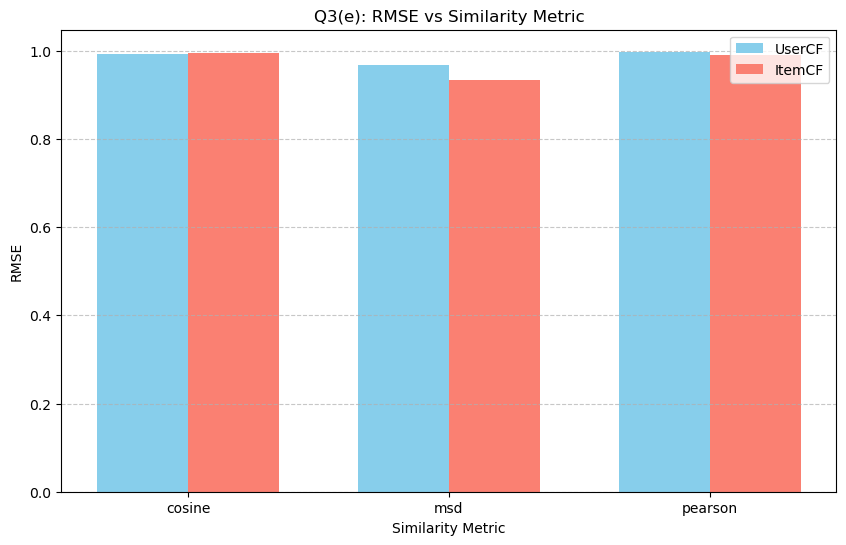

In [17]:
similarities = ['cosine', 'msd', 'pearson']
sim_results = {'UserCF': {}, 'ItemCF': {}}

for sim in similarities:
    print(f"Processing {sim}...")
    for method in ['UserCF', 'ItemCF']:
        # Set up algo with specific similarity
        is_user = (method == 'UserCF')
        algo = KNNBasic(sim_options={'name': sim, 'user_based': is_user}, verbose=False)
        
        # Run CV
        cv = cross_validate(algo, data, measures=['RMSE'], cv=kf, verbose=False)
        sim_results[method][sim] = round(cv['test_rmse'].mean(), 4)

# Convert to DataFrame for easier viewing if needed
df_sim = pd.DataFrame(sim_results)
print("\nSimilarity Results (RMSE):")
print(df_sim)

plt.figure(figsize=(10, 6))
x = np.arange(len(similarities))
width = 0.35

# Plot bars for UserCF and ItemCF
plt.bar(x - width/2, [sim_results['UserCF'][s] for s in similarities], width, label='UserCF', color='skyblue')
plt.bar(x + width/2, [sim_results['ItemCF'][s] for s in similarities], width, label='ItemCF', color='salmon')

plt.title('Q3(e): RMSE vs Similarity Metric')
plt.xlabel('Similarity Metric')
plt.ylabel('RMSE')
plt.xticks(x, similarities)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

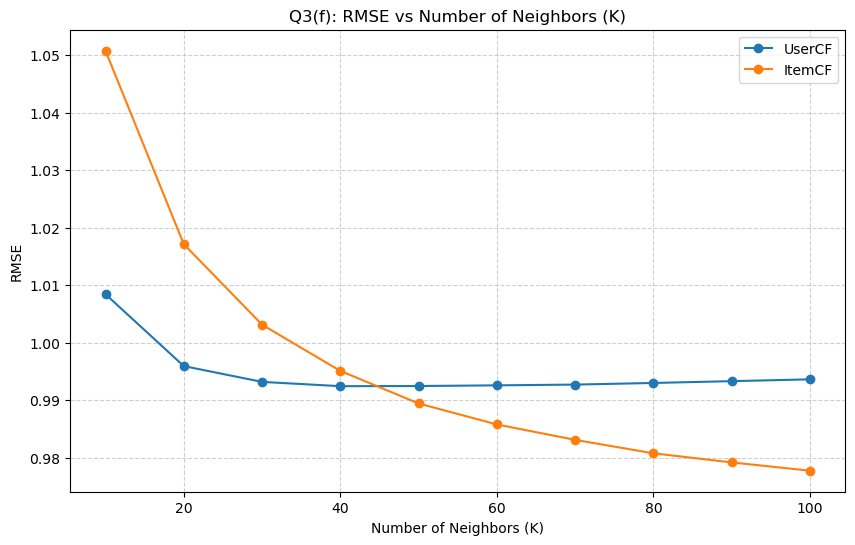

UserCF: Best K = 40 (RMSE = 0.9924)
ItemCF: Best K = 100 (RMSE = 0.9778)


In [18]:
# Range from uploaded code (10 to 100)
k_vals = list(range(10, 101, 10))
rmse_vs_k = {'UserCF': [], 'ItemCF': []}

for k in k_vals:
    for method in ['UserCF', 'ItemCF']:
        # Configure algo with specific K
        is_user = (method == 'UserCF')
        algo = KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': is_user}, verbose=False)
        
        # Run CV
        scores = cross_validate(algo, data, measures=['RMSE'], cv=kf, verbose=False)
        rmse_vs_k[method].append(scores['test_rmse'].mean())

plt.figure(figsize=(10, 6))
for method in ['UserCF', 'ItemCF']:
    plt.plot(k_vals, rmse_vs_k[method], marker='o', label=method)

plt.title('Q3(f): RMSE vs Number of Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

best_k_data = {}
for method in ['UserCF', 'ItemCF']:
    # Find index of minimum RMSE
    min_rmse = min(rmse_vs_k[method])
    best_idx = rmse_vs_k[method].index(min_rmse)
    best_k = k_vals[best_idx]
    
    best_k_data[method] = (best_k, round(min_rmse, 4))
    print(f"{method}: Best K = {best_k} (RMSE = {min_rmse:.4f})")